In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pylab import*
from scipy.io import wavfile
import pandas as pd
import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib
import os
import pickle
import os, fnmatch
from os import listdir
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
#y, sr = librosa.load(librosa.util.example_audio_file())
y, sr = librosa.load('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav')
D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D)

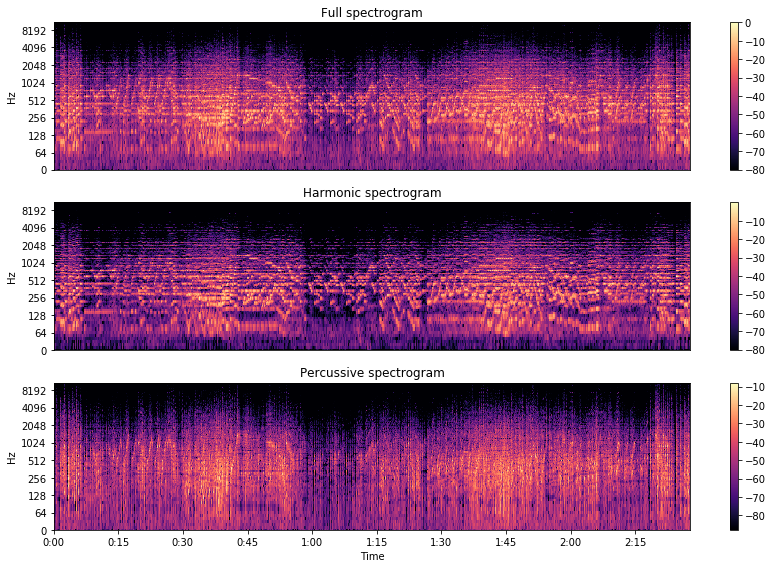

In [3]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

In [4]:
librosa.amplitude_to_db(np.abs(D_percussive))

array([[ -8.595701 ,  -4.691122 , -14.198727 , ..., -28.932877 ,
          2.8228412,  11.0313015],
       [-41.294655 ,  -7.040565 ,  -7.710141 , ...,  -4.9494596,
          4.253995 ,   7.673176 ],
       [-43.445625 ,  -7.9220333,  -9.985163 , ...,   2.331921 ,
         -2.077425 ,  -1.0308219],
       ...,
       [-26.425112 , -32.446182 , -46.490547 , ..., -46.490547 ,
        -46.19224  , -36.327126 ],
       [-26.426426 , -32.44679  , -46.490547 , ..., -46.490547 ,
        -46.202797 , -36.325962 ],
       [-26.426981 , -32.448357 , -46.490547 , ..., -46.490547 ,
        -46.197224 , -36.32643  ]], dtype=float32)

In [5]:
get_ipython().run_line_magic('cd', '/Users/deepanshishokeen/desktop/capstone/work/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot
mod_feat = 'power_modulation_spectrogram' # Controls which version of the amplitude modulation spectrogram

/Users/deepanshishokeen/Desktop/Capstone/work/amplitude-modulation-analysis-module


In [7]:
rms = lambda x: np.sqrt(np.square(x).mean())
dB = lambda y: 10*np.log10(y)
objfun = lambda x: dB(np.mean(x,0).squeeze()+10**(-12))

In [8]:
from statistics import mean
def abs_mod(mod_spec, f_range=np.array([500,4000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None):
    print("Freq Range:", f_range, ", ModFreq Range:", modf_range)
    mn=mod_spec[mod_feat] 
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    if ref is None: 
        rf=mn
    else:
        rf = ref
    w = objfun(mn[midy][:,midx,:])
    print(sum(w))
    print(mean(w))
    p = sum(w), mean(w)
    if ref is not None:
        objfun(rf[midy][:,midx,:])
    return p[0],p[1]

In [9]:
def harmonics_avg_mod(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
    #fs,x = scipy.io.wavfile.read(fname, mmap=True)
    x,fs = librosa.load(fname, sr=None)#returns mono signal
    print(fs,len(x))
    if not len(x):
        print( "File not read:", fname )
        return
    else:
        print ( "Loaded",fname,"len:",len(x) )
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    x_h, x_p = librosa.effects.hpss(x, kernel_size=15, margin=2.5)
    
    if t_range is None:
        t_range = [60,120]
    sig = x_h[t_range[0]*fs:t_range[1]*fs].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig) # normalize RMS 
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    mod_spec = []
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*hop))
        mod_spec.append(ms)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data) 
    nmm = data.mean(0) # average modulation spectrum
    mod_spec[0][mod_feat][:,:,0]=nmm
    return mod_spec[0]


In [10]:
# Default is K448
def get_mod_spec(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
    res = []
    abs_sum = []
    abs_mean = []
    for t in T:
        res.append(harmonics_avg_mod(fname=fname, t_range=[t*60,(t+1)*60]))
        if plotting:
            abs=abs_mod(res[t], ttl='%s, T=%02d:00-%02d:00'%(ttl,t,t+1), avg=avg, ref=ref)
            abs_sum.append(abs[0])
            abs_mean.append(abs[1])
    return res, abs_sum, abs_mean


In [11]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

In [12]:
res_448, sum_448, mean_448 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', avg=True)


44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4465.295862816513
-75.68298072570362
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4431.046640792867
-75.10248543716723
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4589.718524150984
-77.79183939238956


In [13]:
ref_448 = make_reference_mod_spec(res_448)
res_448, sum_448, mean_448 = get_mod_spec(avg=True, ref=ref_448)

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4465.295862816513
-75.68298072570362
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4431.046640792867
-75.10248543716723
44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4589.718524150984
-77.79183939238956


In [14]:
res_545, sum_545, mean_545 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448, avg=True)


44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4530.9523158318425
-76.79580196325158
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4537.288704658877
-76.90319838404876
44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4511.380505127338
-76.46407635809048


In [19]:
mypath= '/Volumes/LaCie/Preferred Music Corpus/Non-western'
print('non western:',len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))
mypath= '/Volumes/LaCie/Preferred Music Corpus/Ambient Music'
print('ambient:',len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))
mypath= '/Volumes/LaCie/Preferred Music Corpus/Heavy Metal'
print('heavy metal:',len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))
mypath="/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll"
print('rock n roll:',len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))
mypath= '/Volumes/LaCie/Preferred Music Corpus/Country/Classic Country'
print('classic country:',len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))

non western: 20
ambient: 60
heavy metal: 107
rock n roll: 314
classic country: 92


In [90]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Non-western'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
print(len([f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]))


z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
    

20
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4583.932729298279
-77.69377507285219
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4408.578452351945
-74.72166868393127
44100 6549144
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/17 Various - The Road to Lisdoon (Ireland).wav len: 6549144
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4360.559069302883
-73.90778083564207
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 6769056
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4668.5960756366685
-79.1287470446893
44100 6769056
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/07 Various - Punleu Prey Viel (Cambodia).wav len: 676905

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4849.297157816528
-82.19147725112758
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4584.596801031741
-77.7050305259617
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4665.079826717134
-79.06914960537515
44100 10213560
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/05 Various - Longod No Yoru No Ame (Japan).wav len: 10213560
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4553.074567363262
-77.17075537903834
44100 8869980
Loaded /Volumes/LaCie/Preferred Music Corpus/Non-western/19 Various - Anasazi Visions (U.S.A).wav len: 8869980
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-5146.546799994796
-87.22960677957283
44100 8869980
Loaded /Volumes/LaCie/Prefer

In [91]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Non-western.xlsx')  
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Non-western.xlsx')

In [ ]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Ambient Music'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4988.039282303436
-84.54303868310909
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-5084.57528899239
-86.1792421863117
44100 13846224
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/01 pimmon - want to fly away.wav len: 13846224
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4967.662494480827
-84.19766939798014
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Three Variations on the "Canon in D Major" by Johann Pachelbel, III： Brutal Ardour.wav len: 21920640
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4569.555763973353
-77.45009769446362
44100 21920640
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/04 Brian Eno - Three Variat

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4406.2795370959675
-74.68270401857573
44100 8824704
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 pimmon - signal is red.wav len: 8824704
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4415.884393291636
-74.84549819138365
44100 8824704
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/07 pimmon - signal is red.wav len: 8824704
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4390.824967483841
-74.42076216074307
44100 20518260
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/08 pimmon - peck spectre.wav len: 20518260
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4475.638087374454
-75.85827266736362
44100 20518260
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/08 pimmon - peck spectre.wav len: 20518260
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4593.7015812078635
-77.85934883403158
44100 20518260
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/08 pimmon - peck spectr

44100 13127100
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/08 Terre Thaemlitz - Fina - Departure.wav len: 13127100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4992.358592839291
-84.61624733625916
44100 13127100
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/08 Terre Thaemlitz - Fina - Departure.wav len: 13127100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4966.933443151244
-84.1853125957838
44100 6624996
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 Brian Eno—David Byrne - A Secret Life.wav len: 6624996
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4503.091978994603
-76.32359286431529
44100 6624996
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 Brian Eno—David Byrne - A Secret Life.wav len: 6624996
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4412.532884653942
-74.78869296023633
44100 6624996
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/09 Brian Eno—David Byrne - A Secret Life.wav len: 6624996


Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4530.111450017444
-76.78155000029567
44100 13411692
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/05 pimmon - voice of sleeping birds.wav len: 13411692
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4513.1409764614355
-76.49391485527856
44100 13411692
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/05 pimmon - voice of sleeping birds.wav len: 13411692
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4532.154254612589
-76.81617380699304
44100 14059080
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 Brian Eno - Taking Tiger Mountain.wav len: 14059080
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4718.478345348197
-79.97420924318978
44100 14059080
Loaded /Volumes/LaCie/Preferred Music Corpus/Ambient Music/10 Brian Eno - Taking Tiger Mountain.wav len: 14059080
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4643.154077229538
-78.69752673270403
44100 14059080
Loaded /Volumes/LaCie/Preferred Mus

In [ ]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Ambience.xlsx')  
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Ambience.xlsx')

In [22]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Heavy Metal'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2613.734740754016
-44.30058882633925
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2476.6743295368865
-41.97753100909977
44100 12815460
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/02 Quiet Riot - Cum On Feel The Noize - Quiet Riot.wav len: 12815460
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2406.9266538049205
-40.79536701364272
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - Old School Hollywood.wav len: 7799820
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1607.5727145626804
-27.246995162079326
44100 7799820
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 System Of A Down - O

44100 12609660
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/15 Judas Priest - The Green Manalishi (With the Two-Pronged Crown) [Fleetwood Mac Cover][Live 21-24.07.1981 in New York, The United States].wav len: 12609660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1887.7665412028068
-31.996043071234013
44100 12609660
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/15 Judas Priest - The Green Manalishi (With the Two-Pronged Crown) [Fleetwood Mac Cover][Live 21-24.07.1981 in New York, The United States].wav len: 12609660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1918.2978489928353
-32.51352286428534
44100 10152996
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Nickelback - Woke Up This Morning.wav len: 10152996
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1900.4370534315087
-32.210797515788286
44100 10152996
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/03 Nickelback - Woke Up This Morning.wav len: 10152996
Freq Range: [1414 28

44100 14014980
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/01 Quiet Riot - Metal Health - Quiet Riot.wav len: 14014980
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2459.185605313868
-41.681111954472335
44100 14116704
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Nickelback - Good Times Gone.wav len: 14116704
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2398.868821811963
-40.65879359003326
44100 14116704
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Nickelback - Good Times Gone.wav len: 14116704
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1958.3386592196762
-33.19218066474027
44100 14116704
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Nickelback - Good Times Gone.wav len: 14116704
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1804.1916534492138
-30.57951954998667
44100 13353480
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/07 Judas Priest - The Sentinel.wav len: 13353480
Freq Range: [1414 2828] , ModF

44100 10241784
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Nickelback - Too Bad.wav len: 10241784
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1490.7220612921856
-25.26647561512179
44100 10241784
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/04 Nickelback - Too Bad.wav len: 10241784
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1882.13058738402
-31.90051843023762
44100 14498316
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/14 Judas Priest - Feed on Me.wav len: 14498316
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2446.5864389977182
-41.467566762673194
44100 14498316
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/14 Judas Priest - Feed on Me.wav len: 14498316
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1790.6492111978455
-30.349986630471957
44100 14498316
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/14 Judas Priest - Feed on Me.wav len: 14498316
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1741.98951241

44100 21344400
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Sunn O))) - CandleGoat.wav len: 21344400


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


44100 21344400
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/05 Sunn O))) - CandleGoat.wav len: 21344400
Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan
44100 8284920
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 Judas Priest - Dissident Aggressor.wav len: 8284920
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2472.6203626851234
-41.90881970652751
44100 8284920
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 Judas Priest - Dissident Aggressor.wav len: 8284920
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1433.954576592306
-24.304314857496713
44100 8284920
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/09 Judas Priest - Dissident Aggressor.wav len: 8284920
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1487.395652289352
-25.210095801514438
44100 10584000
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Night Comes Down.wav len: 10584000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2014.37601

44100 9613800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Nickelback - Where Do I Hide.wav len: 9613800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1784.2421686907387
-30.241392689673532
44100 9613800
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/08 Nickelback - Where Do I Hide.wav len: 9613800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1679.8707923019083
-28.472386310201834
44100 12562620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Quiet Riot - Thunderbird - Quiet Riot.wav len: 12562620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3411.8053366159847
-57.82720909518618
44100 12562620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Quiet Riot - Thunderbird - Quiet Riot.wav len: 12562620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2754.1669620131333
-46.68079596632429
44100 12562620
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/10 Quiet Riot - Thunderbird - Quiet Riot.wav len: 12562620
Freq Range: [

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1476.7723978416393
-25.030040641383714
44100 8986404
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Better by You, Better Than Me [Spooky Tooth Cover].wav len: 8986404
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1897.1019663234783
-32.15427061565218
44100 8986404
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Better by You, Better Than Me [Spooky Tooth Cover].wav len: 8986404
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1670.4771477280972
-28.313171995391478
44100 8986404
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/12 Judas Priest - Better by You, Better Than Me [Spooky Tooth Cover].wav len: 8986404
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1567.6812912513244
-26.570869343242784
44100 7621656
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/01 Motörhead - Iron Fist.wav len: 7621656
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1791.00362

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1681.11874635484
-28.493538073810843
44100 14795844
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/13 Judas Priest - Machine Man.wav len: 14795844
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2856.200305862338
-48.410174675632845
44100 14795844
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/13 Judas Priest - Machine Man.wav len: 14795844
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1731.8622437484244
-29.353597351668206
44100 14795844
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/13 Judas Priest - Machine Man.wav len: 14795844
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1716.3115819062755
-29.090026811970766
44100 11502456
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/01 Nickelback - Never Again.wav len: 11502456
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1702.317049167523
-28.852831341822423
44100 11502456
Loaded /Volumes/LaCie/Preferred Music Corpus/Heavy Metal/01 Nickel

In [23]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/heavy_metal.xlsx') 
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/heavy_metal.xlsx')

In [20]:
my_list=[]
mypath= '/Volumes/LaCie/Preferred Music Corpus/Country/Classic Country'
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4856.31211996055
-82.3103749145856
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4881.417981299857
-82.73589798813317
44100 7107156
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Elton Britt - There's a Star-Spangled Banner Waving Somewhere.wav len: 7107156
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4863.121599422465
-82.42578982071976
44100 8601264
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/02 Ray Charles - You Don't Know Me.wav len: 8601264
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4526.356808172329
-76.71791200292083
44100 8601264
Loaded /Vo

44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4646.058257877818
-78.74675013352233
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4597.664774302694
-77.92652159835075
44100 9874284
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Patsy Cline - Faded Love.wav len: 9874284
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4677.472846468776
-79.27920078760638
44100 7472304
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Jimmie Davis - You Are My Sunshine.wav len: 7472304
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4761.6084190483525
-80.7052274414975
44100 7472304
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Jimmie Davis - You Are My Sunshine.wav len: 

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4366.786204716825
-74.01332550367499
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4620.8816058568045
-78.32002721791193
44100 7688100
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/01 Jerry Lee Lewis - You Win Again.wav len: 7688100
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4446.452203346311
-75.36359666688664
44100 6809040
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Eddy Arnold - I Really Don't Want to Know.wav len: 6809040
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4890.054065092531
-82.88227228970392
44100 6809040
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Eddy Arnold - I Really Don't Want to Know.wav len: 6809040
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4833.522636722886
-81.92411248682858
4410

44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4842.170369680587
-82.07068423187437
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4869.764811105406
-82.53838662890517
44100 7242396
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/24 Ted Daffan's Texans - Born to Lose.wav len: 7242396
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4981.896098228277
-84.43891691912334
44100 6877836
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tennessee Ernie Ford - Sixteen Tons.wav len: 6877836
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-5068.2300944826475
-85.90220499123132
44100 6877836
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tennessee Er

44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4753.787128699782
-80.57266319830141
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4675.731591528409
-79.24968799200693
44100 8370180
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/16 Patsy Montana and the Prairie Ramblers - I Want to Be a Cowboy's Sweetheart.wav len: 8370180
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4746.356040619885
-80.44671255287939
44100 8580096
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/06 Ray Charles - Born To Lose.wav len: 8580096
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4618.468959839482
-78.

44100 7774536
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/08 Riley Puckett - Ragged But Right.wav len: 7774536
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4947.364544479026
-83.85363634710214
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4631.479606465124
-78.4996543468665
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4703.712112142677
-79.72393410411317
44100 8738856
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/25 Tom T. Hall - Homecoming.wav len: 8738856
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4686.746314892827
-79.43637821852248
44100 8176140
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/04 Vernon Dalhart - The Prisoner's Song.wav len: 8

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4448.542028730685
-75.39901743611331
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4569.107694186376
-77.4425032912945
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4590.21408774819
-77.80023877539303
44100 7968576
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/07 The Maddox Brothers & Rose - Philadelphia Lawyer.wav len: 7968576
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4529.074405588225
-76.76397297607161
44100 8023260
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/15 Pee Wee King - Tennessee Waltz.wav len: 8023260
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4714.665035788

Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4891.385842725969
-82.90484479196559
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4828.040230632019
-81.83119034969523
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4913.8546037146925
-83.28567124940157
44100 7214760
Loaded /Volumes/LaCie/Preferred Music Corpus/Country/Classic Country/17 Hank Williams - Lovesick Blues.wav len: 7214760
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
-4928.9764994399075
-83.54197456677811


In [21]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/classiccountry.xlsx') 
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/classiccountry.xlsx')

In [26]:
my_list=[]
mypath= "/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll"
files = [f for f in os.listdir(mypath) if f.endswith(".wav") and not f.startswith("._")]
files

z = []
new_list=[]
slash='/'
for j in files:
    ttl=j.replace('.wav','')
    whole_path=mypath+slash+j
    sampFreq, snd = wavfile.read(whole_path)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(whole_path,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)
  

44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2596.649710833561
-44.01101204802646
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2361.9262943481326
-40.032649056748006
44100 11601240
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Elton John & Kiki Dee - Don't Go Breaking My Heart.wav len: 11601240
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2284.035531338573
-38.712466632857165
44100 10504620
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Joe Cocker & Jennifer Warnes - Up Where We Belong.wav len: 10504620
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3511.73529685208
-59.52093723478102
44100 10504620
Loaded /Volumes/LaCie/Preferred Music 

44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2526.3887920860598
-42.8201490184078
44100 6613824
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Terry Stafford - Suspicion.wav len: 6613824
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2576.5642406151114
-43.67058034940867
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2489.741232907562
-42.199003947585794
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2496.5304760311133
-42.31407586493413
44100 7646940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Tommy James & The Shondells - Mony Mony.wav len: 7646940
Freq Range: [14

44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2146.8251552534034
-36.38686703819328
44100 6925464
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Bobby Vee - Take Good Care of My Baby.wav len: 6925464
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2629.9585522200823
-44.57556868169631
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2772.015950565001
-46.983321196016966
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2513.845741265434
-42.607554936702265
44100 7958580
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 The Miracles - Love Machine - Pt. 1.wav len: 7958580
Freq

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2294.760240127048
-38.894241358085566
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2275.676022767367
-38.57078004690453
44100 6387444
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 The Lemon Pipers - Green Tambourine.wav len: 6387444
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3385.968329711909
-57.38929372393066
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2583.430502838095
-43.78695767522195
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion - Runaround Sue.wav len: 7160664
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2620.5108122181878
-44.41543749522353
44100 7160664
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Dion -

44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2838.8338583696163
-48.115828107959594
44100 6582660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Buddy Holly - Peggy Sue.wav len: 6582660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3280.7604612835225
-55.60610951328004
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2372.188958967705
-40.20659252487634
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2278.6237746754646
-38.62074194365194
44100 6326880
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Coasters - Charlie Brown.wav len: 6326880
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2633.3895944604

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2160.5870744397903
-36.620119905759154
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2625.3302615959565
-44.49712307789757
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2525.8449223541156
-42.81093088735789
44100 7933884
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Various - Jackson 5 - I Want You Back.wav len: 7933884
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2736.3701555939583
-46.379155179558616
44100 7620480
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Crests - Sixteen Candles.wav len: 7620480
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2597.7673761946858
-44.02995552872349
44100 7620480
Loaded /Volumes/LaCie/Preferred Music

44100 7026600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 The Lovin' Spoonful - Summer In The City.wav len: 7026600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2878.786010924508
-48.79298323600862
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2407.4074242820666
-40.80351566579774
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2202.5985609480367
-37.33217899911927
44100 8639484
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Stray Cats - Stray Cat Strut.wav len: 8639484
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2061.95704539987
-34.94842449830288
44100 7427616
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Tommy James - Draggin' The Line.wav len: 7427616
Freq Range: [1414 2828] , ModFr

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2041.353778435604
-34.5992165836543
44100 6470940
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 The Marvelettes - Please Mr. Postman.wav len: 6470940
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2380.8048379849347
-40.35262437262602
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2237.2768951335147
-37.91994737514432
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2105.010895744282
-35.67815077532681
44100 6906060
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Angels - My Boyfriend's Back.wav len: 6906060
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2200.601853478539
-37.29833649963626
44100 7150080
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Freq Range: [1414 2828] , ModFreq Range: [30 60]
nan
nan


/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 59 results
  r = func(a, **kwargs)


44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2684.591597578945
-45.50155250133805
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2254.3017191969307
-38.20850371520221
44100 8568924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Elton John - Goodbye Yellow Brick Road.wav len: 8568924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2119.9128393205137
-35.9307260901782
44100 7965048
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Shirley Ellis - The Name Game.wav len: 7965048
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2552.663412717917
-43.26548157149012
44100 7965048
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Shirley Ellis - The Name Game.wav len: 7965048
Freq Range: [1

44100 12306840
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Oliver - Good Morning Starshine.wav len: 12306840
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2709.2294249422275
-45.91914279563097
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2649.2811171484746
-44.90306978217754
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2278.9615960817982
-38.62646773019997
44100 8754144
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - America - Sister Golden Hair.wav len: 8754144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1943.9323436099328
-32.94800582389716
44100 6332760
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Gene Chandler - Duke of Earl.wav len: 6332760
Freq Ran

44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1962.763972856176
-33.26718598061315
44100 7833924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Yvonne Elliman - If I Can't Have You.wav len: 7833924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2185.288168462382
-37.038782516311564
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2481.3922015509816
-42.05749494154206
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2488.1639442376163
-42.17227024131553
44100 8937600
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various - Edwin Starr - War.wav len: 8937600
Freq Range: [1414 2828] , ModFr

44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2383.8277030057575
-40.40385937297895
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2322.9127465582264
-39.37140248403774
44100 6258084
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Santo And Johnny - Sleep Walk.wav len: 6258084
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2786.8306674929754
-47.23441809310129
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Daryl Hall & John Oates - Kiss on My List.wav len: 10112424
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2206.908997123082
-37.405237239374266
44100 10112424
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/08 Daryl Hall & John Oates - Kiss on My List.wav len: 10112424
Freq Range

44100 8127924
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Various - Shocking Blue - Venus.wav len: 8127924
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2459.8591986148926
-41.69252879008293
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2636.641854668791
-44.688844994386294
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2528.7502940819895
-42.86017447596593
44100 9827244
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/01 Men At Work - Down Under.wav len: 9827244
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2456.973157181444
-41.643612833583795
44100 9323916
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/03 Bonnie Tyler - It's A Heartache.wav len: 9323916
Freq Range: [1414 2828] , ModFreq Range: [30 60]


44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2196.0219889052205
-37.22071167635967
44100 7063644
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 The Tokens - The Lion Sleeps Tonight.wav len: 7063644
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2372.4318558945906
-40.21070942194221
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3198.494279754485
-54.21176745346585
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 9349200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2599.7033943132983
-44.06276939514065
44100 9349200
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various Artists - Rose Royce - Car Wash.wav len: 934

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2336.408751716288
-39.600148334174364
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2340.0669320430275
-39.6621513905598
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2229.309082817118
-37.78489970876471
44100 8487780
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/10 Various - KC & The Sunshine Band - Get Down Tonight.wav len: 8487780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2127.350879432006
-36.056794566644164
44100 6225744
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/02 Chuck Berry - Maybellene.wav len: 6225744
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2421.7012312748266
-41.04578358092926
44100 6225744

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2557.471263811116
-43.346970573069754
44100 7354116
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Bill Haley & The Comets - See You Later, Alligator.wav len: 7354116
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1984.918544619423
-33.64268719693938
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2214.0538582829995
-37.52633658106779
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-1948.1737788821083
-33.01989455732387
44100 10187100
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Laura Branigan - Gloria.wav len: 10187100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2100.3721852204426
-35.59952856305834
44100 9365

44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2382.277417573101
-40.377583348696625
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2286.4253302461325
-38.75297169908699
44100 6262788
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/07 Len Barry - One Two Three.wav len: 6262788
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2539.4860830772905
-43.04213700131
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav len: 8694756
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2800.3125173385197
-47.46292402268677
44100 8694756
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/09 Various Artists - Climax Blues Band - Couldn't Get It Right.wav len: 8

44100 9081660
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/05 The Edgar Winter Group - Frankenstein.wav len: 9081660
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2427.6576706987044
-41.146740181333975
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2052.191682384128
-34.78290987091742
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2015.3784586282
-34.15895692590169
44100 7302960
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Beach Boys - Help Me Rhonda.wav len: 7302960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2222.341817093224
-37.66681045920719
44100 9233364
Loaded /Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/06 Little River Band - Reminiscing.wav len: 9233364
Freq Range: [1414 2828] , ModFreq Rang

FileNotFoundError: [Errno 2] No such file or directory: "/Volumes/LaCie/Preferred Music Corpus/Rock n' Roll/04 Various Artists - Peter Frampton - I'm In You.wav"

In [27]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/rock_n_roll.xlsx') 
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/rock_n_roll.xlsx')

In [33]:
roots=[]
files=[]
my_list=[]
mypath= '/Volumes/LaCie/PSYC90 Corpus Study'
for root, dirnames, filenames in os.walk(mypath):
    for filename in filenames:
        if filename.endswith('.wav') and not filename.startswith("._"):
                files.append(os.path.join(filename))
                roots.append(os.path.join(root,filename))

z = []
slash='/'
for i,j in zip(roots,files):
    ttl=j.replace('.wav','')
    sampFreq, snd = wavfile.read(i)
    if snd.shape[0]/sampFreq > 140: 
        res,abs_sum,abs_mean=get_mod_spec(i,ttl=ttl, ref=ref_448, avg=True)
        ttl=[ttl+'(1)',ttl+'(2)',ttl+'(3)']
        for i in range(3):
            z=ttl[i],abs_sum[i],abs_mean[i]
            my_list.append(z)

44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4426.602664644061
-75.02716380752646
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4480.3085469622365
-75.93743299935993
44100 26118960
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/10 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #1 Ranz De Vaches： Mélodie De Ferdinand Huber, Avec Variations.wav len: 26118960
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3963.453726858769
-67.17718181116558
44100 36501864
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Lis

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4790.946640584796
-81.20248543364062
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4358.674043730564
-73.87583124967058
44100 7114800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/02 Leslie Howard - Liszt： Années De Pèlerinage, Première Année, Suisse, S 160 - 2. Au Lac De Wallenstadt.wav len: 7114800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-5207.4164118407825
-88.26129511594546
44100 19718580
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 1st Annèe de Pèlerinage/12 Leslie Howard - Liszt： 3 Morceaux Suisses, S 156a - #3 Ranz De Chèvres： Mélodie De Ferdinand Huber, "Rondeau".wav len: 19718580
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3613.374855059536
-61.243641611178575


Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4503.460902886628
-76.32984581163777
44100 10384080
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/09 Franz Liszt - Venezia e Napoli – Supplement aux Années de Pèlerinage seconde volume, S162： II. Canzone.wav len: 10384080
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3862.2177391492514
-65.46131761269918
44100 15658440
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/05 Franz Liszt - Années de pèlerinage, deuxième année – Italie, S161： V. Sonetto 104 del Petrarca.wav len: 15658440
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4191.342886887949
-71.03970994725337
44100 15658440
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 2nd Année de Pélerinage/05 Franz Liszt - Années de pèlerinage, deuxième année – Italie, S161： V. Sonetto 104 del Petrarca.wav len: 15658440
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4135.735997361918
-70.0972202942698
44100 15658440
Load

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4493.217321187902
-76.15622578284578
44100 18595500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/02 Mitsuko Uchinda - Piano Sonata KV 545 in C ("For beginners")： II. Andante.wav len: 18595500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4486.923899081105
-76.04955761154417
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3572.3720950703228
-60.54867957746309
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3646.382524942724
-61.80309364309703
44100 19992000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/10 Mitsuko Uchinda - Piano Sonata KV 533 & 494 in F： I. Allegro.wav len: 19992000
Freq Range: [1414 2828] , ModF

44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3773.2171590663543
-63.95283320451448
44100 9757860
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.545/09 Lubimov, A. - III. Allegretto.wav len: 9757860
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3812.5889825200966
-64.62015224610333
44100 20978076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.448 Files/02 Wolfgang Amadeus Mozart - Sonata for Two Pianos in D major, K. 375a／448： II. Andante.wav len: 20978076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-5317.7296328003795
-90.13101072543017
44100 20978076
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K.448 Files/02 Wolfgang Amadeus Mozart - Sonata for Two Pianos in D major, K. 375a／448： II. Andante.wav len: 20978076
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-5391.432389898006
-91.38020999827128
44100 20978076
Loaded /Volumes/LaCie/PSYC90 Cor

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4499.662340361174
-76.2654633959521
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4195.069413822475
-71.10287142071991
44100 14920500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/12 Leslie Howard ／ Complete Piano Music by Leslie Howard - Historical Hungarian Portraits, S205： Mosonyi Mihály (Michael Mosonyi).wav len: 14920500
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4513.273781299962
-76.49616578474513
44100 9079896
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz 3rd Année de Pélerinage/14 Leslie Howard ／ Complete Piano Music by Leslie Howard - Ungarns Gott, transcribed for the left hand, S543a.wav len: 9079896
Freq Range: [1414 2828] , ModFreq Range: [30 60]


44100 17992800
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/05 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B Op9 No3.wav len: 17992800
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3952.374083320971
-66.98939124272832
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B flat minor Op9 No1.wav len: 18125100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4571.099708804807
-77.47626625092892
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B flat minor Op9 No1.wav len: 18125100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4118.772114137926
-69.80969684979536
44100 18125100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Listz Paganini Etudes/03 Nikita Magaloff - Frederic Chopin (1810-1849) - Nocturne in B flat minor Op9 No1.wav len: 18125100
Freq Range: [1414 2828] , 

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4362.620124411329
-73.94271397307338
44100 15381492
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/01 Ludwig van Beethoven - Piano Sonata no. 13 in E-flat, op. 27 no. 1 "Quasi una fantasia"： I. Andante - Allegro - Tempo I.wav len: 15381492
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4290.482758309848
-72.72004675101435
44100 18630780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/06 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Rigoletto (Verdi)： Preludio.wav len: 18630780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4225.156086782296
-71.61281503020841
44100 18630780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/06 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Rigoletto (Verdi)： Preludio.wav len: 18630780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4362.044470790876
-73.93295713204877
44100 18630780
Loaded /Vol

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4723.904548071106
-80.06617878086617
44100 41650980
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/22 Leslie Howard - Gretchen aus Faust-Symphonie, S513.wav len: 41650980
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4460.888427914267
-75.60827843922486
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Aida (Verdi)： Danza sacra.wav len: 15470280
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4755.7268823964305
-80.60554037960053
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata in B minor ／ Concert Paraphrases - Concert Paraphrases - Aida (Verdi)： Danza sacra.wav len: 15470280
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4705.097856455544
-79.74742129585667
44100 15470280
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/04 Liszt ／ Sonata

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4959.102331633068
-84.0525818920859
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3747.4026747052358
-63.515299571275186
44100 14266056
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/07 Leslie Howard - Piano Sonata in B minor, S178, 007 Andante sostenuto.wav len: 14266056
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-2976.8571200687534
-50.455205424894125
44100 10065384
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/11 Franz Schubert - Fantasy in C, D 760 "Wanderer"： IV. Allegro.wav len: 10065384
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3342.8377035920844
-56.658266162577696
44100 10065384
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/11 Franz Schubert - Fantasy in C, D 760 "Wanderer"： IV. Alleg

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4464.227966348215
-75.66488078556297
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4262.414291338952
-72.2443100226941
44100 13274100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mitsuko Uchida - Piano Sonata No. 12 in F major, K. 332 (K. 300k)： Adagio.wav len: 13274100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4603.2671380291795
-78.0214769157488
44100 20706420
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/09 Mozart - Sonata for Piano in C minor, K457-2 - Adagio.wav len: 20706420
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4289.49725731683
-72.70334334435306
44100 20706420
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/09 Mozart - Sonata for Piano in C minor, K457-2 - Adagio.wav len: 20706420
Freq Range: [1414 2828] , ModF

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3512.2504480328207
-59.52966861072577
44100 17454780
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/03 Mozart - Sonata for Piano in F Major, K332-3 - Allegro Assai.wav len: 17454780
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3788.2525210248305
-64.20766984787849
44100 14051436
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mozart - Sonata for Piano in F Major, K332-2 - Adagio.wav len: 14051436
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4572.672091617634
-77.50291680707855
44100 14051436
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mozart - Sonata for Piano in F Major, K332-2 - Adagio.wav len: 14051436
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4684.93279530034
-79.40564059831084
44100 14051436
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Mozart K. 333/02 Mozart - Sonata for Piano in F Major, K332-2 - Adagio.wav len: 14051436
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4416.55676

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3491.064310347148
-59.17058153130758
44100 24078600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Wolfgang Amadeus Mozart - Sonata no. 12 in F major, KV 332： I. Allegro.wav len: 24078600
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3526.697525239952
-59.774534326100884
44100 32862144
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Mozart, W A：  - Fantasia for Pno No 14a in C minor, K 475： Adagio： Allegro： Più allegro： Primo tempo(1).wav len: 32862144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4462.449113383682
-75.63473073531664
44100 32862144
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Mozart, W A：  - Fantasia for Pno No 14a in C minor, K 475： Adagio： Allegro： Più allegro： Primo tempo(1).wav len: 32862144
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3661.360425602275
-62.056956366140255
44100 32862144
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/01 Mozart, W A：  - Fantasi

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4261.182331025363
-72.22342933941292
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： II. Andante cantabile.wav len: 17199000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4160.8807368078715
-70.52340231877749
44100 17199000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/02 Wolfgang Amadeus Mozart - Sonata no. 10 in C major, KV 330： II. Andante cantabile.wav len: 17199000
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4266.037832287463
-72.30572597097394
44100 21653100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Ronald Brautigam - Sonata No.17 in B flat major, KV.570 - II. Adagio.wav len: 21653100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-4429.088252820787
-75.0692924206913
44100 21653100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Ronald Brautigam - Sonata No.17 in B flat major, KV.570 - II. Adagio.wav 

Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3564.965607357066
-60.423145887407905
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.wav len: 11410140
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3469.625663244916
-58.807214631269765
44100 11410140
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Mozart, W A： Son for Pno No 16 in C major, K 545 "Son Facile" - 001 Allegro.wav len: 11410140
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3555.1056932873444
-60.2560286997855
44100 8467200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/09 Wolfgang Amadeus Mozart - Sonata no. 9 in A minor, KV 310： III. Presto.wav len: 8467200
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3217.3665645906676
-54.531636687977425
44100 8467200
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/09 Wolfgang Amadeus Mozart - Sonata no. 9 in A minor, KV 310： III. Presto.wav len: 84

44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3490.887644671346
-59.16758719781943
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3458.9809630283103
-58.62679598353068
44100 17243100
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/04 Wolfgang Amadeus Mozart - Sonata no. 8 in D major, KV 311： I. Allegro con spirito.wav len: 17243100
Freq Range: [1414 2828] , ModFreq Range: [30 60]
-3388.235198815609
-57.427715234162854
44100 14332500
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/08 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for Piano duet in B flat, K.358 - 2. Adagio.wav len: 14332500
Freq Range: [1414 2828] , ModFreq 

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/11 Ingrid Haebler, Ludwig Hoffmann - Mozart： Sonata for 2 pianos in D, K.448 - 2. Andante.wav'

In [34]:
df = pd.DataFrame(my_list, columns = ['Title', 'Absolute power(dB)sum', 'Absolute power(dB)mean'])
df=df.sort_values(by=['Absolute power(dB)mean'], ascending=False)
df.to_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/classical.xlsx') 

In [ ]:
df_class = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/classical.xlsx')
df_amb = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Ambience.xlsx')
df_rnr = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/rock_n_roll.xlsx')
df_hm = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/heavy_metal.xlsx')
df_cc = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/classiccountry.xlsx')
df_nw = pd.read_excel('/Users/deepanshishokeen/Desktop/Music/abs_pow_harmonic/Non-western.xlsx')

In [51]:
print(df_class.head(3))
print(df_class.tail(3))

                                                 Title  Absolute power(dB)sum  \
192  31 Nikita Magaloff - Robert Schumann (1810-185...           -2748.854023   
146  21 Leslie Howard ／ Complete Piano Music by Les...           -2912.288220   
273  23 Leslie Howard - Totentanz, S525 for solo piano           -2915.733900   

     Absolute power(dB)mean  
192              -46.590746  
146              -49.360817  
273              -49.419219  
                                                 Title  Absolute power(dB)sum  \
127  02 Wolfgang Amadeus Mozart - Sonata for Two Pi...           -5391.432390   
15   09 Leslie Howard - Liszt： Années De Pèlerina...           -5424.635587   
276  09 Franz Schubert - Fantasy in C, D 760 "Wande...           -5473.350438   

     Absolute power(dB)mean  
127              -91.380210  
15               -91.942976  
276              -92.768651  


In [52]:
print(df_amb.head(3))#02 Aphex Twin - Flaphead-  Non vocal
print(df_amb.tail(3))

                            Title  Absolute power(dB)sum  \
107      02 Aphex Twin - Flaphead           -2143.512944   
53   02 pimmon - bird cage circus           -2236.853397   
106      02 Aphex Twin - Flaphead           -2244.413191   

     Absolute power(dB)mean  
107              -36.330728  
53               -37.912769  
106              -38.040902  
                              Title  Absolute power(dB)sum  \
69    01 Brian Eno - Discreet Music           -4904.666355   
81  04 Jacob Kirkegaard - Gymnasium           -5030.346391   
18          10 pimmon - cakewalking                    NaN   

    Absolute power(dB)mean  
69              -83.129938  
81              -85.260108  
18                     NaN  


In [53]:
print(df_rnr.head(3))# 01 Queen - We Are The Champions- Vocal
print(df_rnr.tail(3))#09 Various Artists - Joe Cocker & Jennifer Warnes - Up Where We Belong- Vocal

                                        Title  Absolute power(dB)sum  \
140           01 Queen - We Are The Champions           -1732.014547   
202                  02 Del Shannon - Runaway           -1784.038979   
367  02 Grand Funk Railroad - The Loco‐Motion           -1810.363863   

     Absolute power(dB)mean  
140              -29.356179  
202              -30.237949  
367              -30.684133  
                                                 Title  Absolute power(dB)sum  \
3    09 Various Artists - Joe Cocker & Jennifer War...           -3511.735297   
302                    04 Gene Vincent - Be-Bop-A-Lula                    NaN   
335                 07 Freddy Cannon - Way Down Yonder                    NaN   

     Absolute power(dB)mean  
3                -59.520937  
302                     NaN  
335                     NaN  


In [57]:
print(df_hm.head(3))# 16 Judas Priest - Solar Angels -Vocal
print(df_hm.tail(5))
#06 Sunn O))) - Cry For The Weeper
#03 Sunn O))) - Cursed Realms 

                                              Title  Absolute power(dB)sum  \
209                  16 Judas Priest - Solar Angels           -1061.693716   
260                09 System Of A Down - Sad Statue           -1152.850908   
257  10 Judas Priest - Some Heads Are Going to Roll           -1197.501678   

     Absolute power(dB)mean  
209              -17.994809  
260              -19.539846  
257              -20.296639  
                                                 Title  Absolute power(dB)sum  \
192           10 Quiet Riot - Thunderbird - Quiet Riot           -3411.805337   
147                  06 Sunn O))) - Cry For The Weeper           -3461.386586   
84   03 Sunn O))) - Cursed Realms (Of The Winterdem...           -3567.649271   
151                          05 Sunn O))) - CandleGoat                    NaN   
152                          05 Sunn O))) - CandleGoat                    NaN   

     Absolute power(dB)mean  
192              -57.827209  
147              -58

In [59]:
print(df_cc.head(3))#27 The Everly Brothers - Bye Bye Love
print(df_cc.tail(3))#16 Roger Miller - King of the Road

                                                 Title  Absolute power(dB)sum  \
114  02 Uncle Dave Macon and his Fruit Jar Drinkers...           -1947.000302   
64                           04 Ray Price - Crazy Arms           -2012.035967   
24               27 The Everly Brothers - Bye Bye Love           -2037.749544   

     Absolute power(dB)mean  
114              -33.000005  
64               -34.102305  
24               -34.538128  
                                  Title  Absolute power(dB)sum  \
56         09 Jimmy Dean - Big Bad John           -3375.827553   
239    03 Johnny Cash - I Walk the Line           -3451.453063   
170  16 Roger Miller - King of the Road           -4077.065162   

     Absolute power(dB)mean  
56               -57.217416  
239              -58.499204  
170              -69.102799  


In [62]:
print(df_nw.head(3))#03 Bill Monroe & His Bluegrass Boys - When He - vocal
print(df_nw.tail(7))#15 Various - Voices (U.S.A)

                                                Title  Absolute power(dB)sum  \
13                       01 Various - Dounya (Guinea)           -2469.595084   
54  03 Bill Monroe & His Bluegrass Boys - When He ...           -2590.091159   
56  03 Bill Monroe & His Bluegrass Boys - When He ...           -2613.010983   

    Absolute power(dB)mean  
13              -41.857544  
54              -43.899850  
56              -44.288322  
                                         Title  Absolute power(dB)sum  \
40  05 Various - Longod No Yoru No Ame (Japan)           -4140.338832   
49           13 Various - Songline (Australia)           -4342.324159   
36                 15 Various - Voices (U.S.A)           -4365.403841   
44        19 Various - Anasazi Visions (U.S.A)           -4456.606001   
43        19 Various - Anasazi Visions (U.S.A)           -4662.286717   
42        19 Various - Anasazi Visions (U.S.A)           -4767.342777   
48           13 Various - Songline (Australia)      

In [44]:
# selecting 60 samples randomly to represent the genre
import random
sample_df_class = df_class.sample(60)
sample_df_amb = df_amb.sample(60)
sample_df_rnr = df_rnr.sample(60)
sample_df_hm = df_hm.sample(60)
sample_df_cc = df_cc.sample(60)
sample_df_nw = df_nw
#sample_df_nw = random.sample(the_list, 60)

In [48]:
# combining music pieces from all genres
df = df_cc.append(df_amb, ignore_index=True)
df = df.append(df_nw,ignore_index=True)
df = df.append(df_hm,ignore_index=True)
df = df.append(df_class,ignore_index=True)
df = df.append(df_rnr,ignore_index=True)

sample_df = df_cc.append(sample_df_amb, ignore_index=True)
sample_df = df.append(sample_df_nw,ignore_index=True)
sample_df = df.append(sample_df_hm,ignore_index=True)
sample_df = df.append(sample_df_class,ignore_index=True)
sample_df = df.append(sample_df_rnr,ignore_index=True)

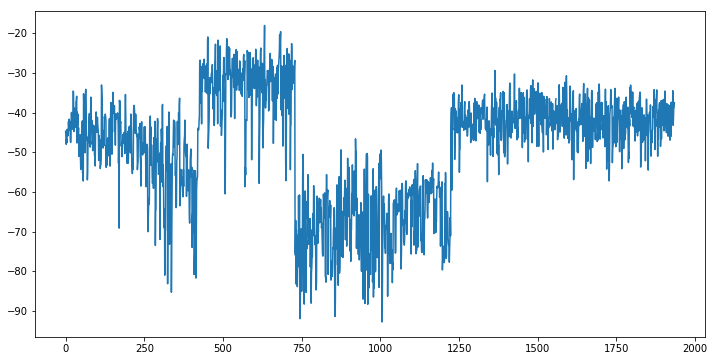

In [49]:
plot(sample_df.values[:,2])

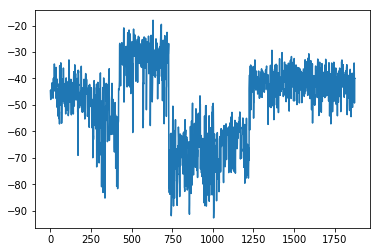

In [29]:
plot(df.values[:,2])

Text(0,0.5,'count')

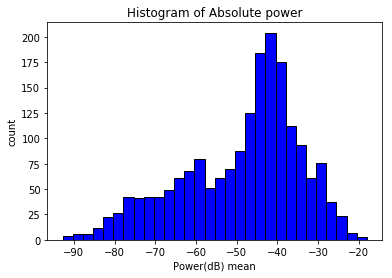

In [15]:
plt.hist(df['Absolute power(dB)mean'], color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

Text(0.5,0,'Power(dB) mean')

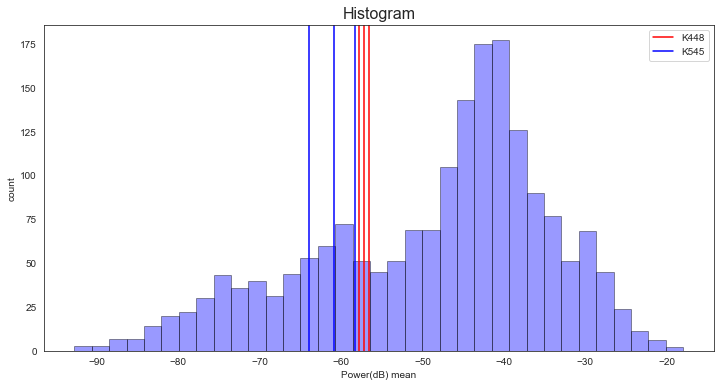

In [68]:
# seaborn histogram
sns.distplot(df['Absolute power(dB)mean'].dropna(), hist=True, kde=False, bins=35, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.axvline(x=-57.77, color='red', label='K448')
plt.axvline(x=-57.19, color='red')
plt.axvline(x=-56.54, color='red')
plt.axvline(x=-63.99, color='blue', label='K545')
plt.axvline(x=-60.88, color='blue')
plt.axvline(x=-58.36, color='blue')
plt.legend()
plt.title('Histogram', fontsize=16)
plt.ylabel('count')
plt.xlabel('Power(dB) mean')

Text(0,0.5,'count')

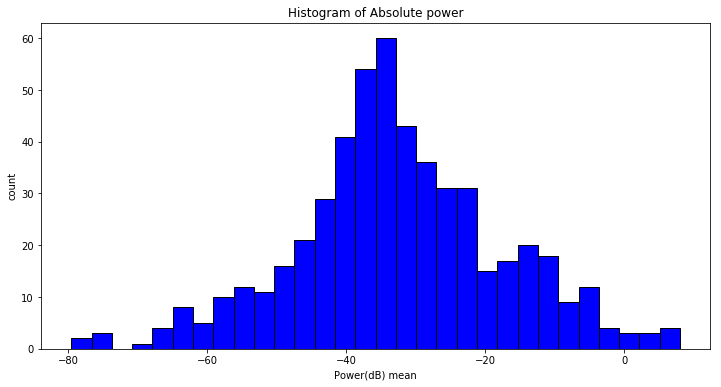

In [62]:
# matplotlib histogram
plt.hist(df['Absolute power(dB)mean'].dropna(), color = 'blue', edgecolor = 'black', bins=30)
# Add labels
plt.title('Histogram of Absolute power')
plt.xlabel('Power(dB) mean')
plt.ylabel('count')

/Users/deepanshishokeen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

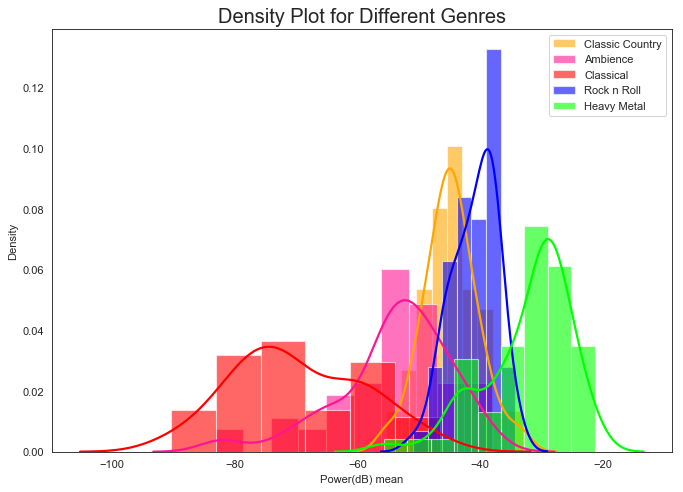

In [72]:
import seaborn as sns
sns.set_style("white")

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
#sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
sns.distplot(sample_df_cc['Absolute power(dB)mean'].dropna(), color="orange", label="Classic Country", **kwargs)
sns.distplot(sample_df_amb['Absolute power(dB)mean'].dropna(), color="deeppink", label="Ambience", **kwargs)
#sns.distplot(sample_df_nw['Absolute power(dB)mean'].dropna(), color="b", label="Non Western", **kwargs)
sns.distplot(sample_df_class['Absolute power(dB)mean'].dropna(), color="red", label="Classical", **kwargs)
sns.distplot(sample_df_rnr['Absolute power(dB)mean'].dropna(), color="b", label="Rock n Roll", **kwargs)
sns.distplot(sample_df_hm['Absolute power(dB)mean'].dropna(), color="lime", label="Heavy Metal", **kwargs)


plt.legend();
plt.title('Density Plot for Different Genres', size = 18)
plt.xlabel('Power(dB) mean')
plt.ylabel('Density')
